In [11]:
import pandas as pd
import numpy as np
import pandahouse as ph
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230620',
              'user':'student',
              'password':'dpo_python_2020'
             }

query = '''
select exp_group,
       user_id, 
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes,
       likes / views as ctr
from {db}.feed_actions 
where toDate(time) between toDate('2023-05-24') and toDate('2023-05-30')
and exp_group in (2, 3)
group by exp_group, user_id 
'''

df = ph.read_clickhouse(query, connection=connection)

Примерно по 8,5 тысяч пользователей в каждой из групп:

In [3]:
df.exp_group.value_counts()

exp_group
3    8569
2    8480
Name: count, dtype: int64

Проводим 10 000 А/А-тестов, на каждом из которых формируем подвыборку без повторения в 500 юзеров из 2 и 3 экспериментальной группы и сравниваем эти подвыборки t-testом.

In [4]:
p_vals = np.empty(10000)

for i in tqdm(range(10000)):
    df_3 = df[df.exp_group == 3].sample(500, replace=False)
    df_2 = df[df.exp_group == 2].sample(500, replace=False)
    
    p_vals[i] = stats.ttest_ind(df_2.ctr, df_3.ctr)[1]

100%|██████████| 10000/10000 [00:58<00:00, 172.26it/s]


Гистограмма распределения получившихся 10 000 p-values

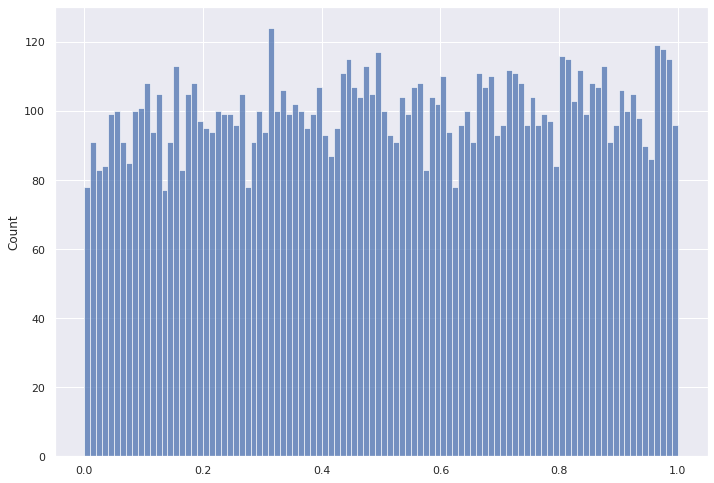

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(p_vals, bins=100);

Процент p values меньше либо равен 0.05:

In [7]:
len(p_vals[p_vals <= 0.05]) / len(p_vals)

0.0435

ВЫВОД: Доля значимых отклонений подвыборок (случаев, когда на очередной итерации сравнений подвыборок вероятность получения таких или более выраженных различий при условии верности нулевой гипотезы о принадлежности подвыборок одной генеральной совокупности составила менее 5 %, что давало основания отклонить нулевую гипотезу) - из всех проведенных 10 тыс. АА тестов составила 4,35 %, что так же составляет менее 5 %. На основе этого можно сделать вывод об отсутствии различий по ключевой метрике в сравниваемых группах - система сплитования работает корректно.

Дополнительно проведем общее сравнение t тестом метрики по полным группам - значение pvalue 0,46 значительно превышает принятый уровень значимости 0,05, что НЕ дает основания отклонить нулевую гипотезу. Гистограмма распределения ключевой метрики по группам так же показывает схожесть ее распределения.

In [8]:
stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr)

Ttest_indResult(statistic=-0.739345952217475, pvalue=0.4597071328702571)

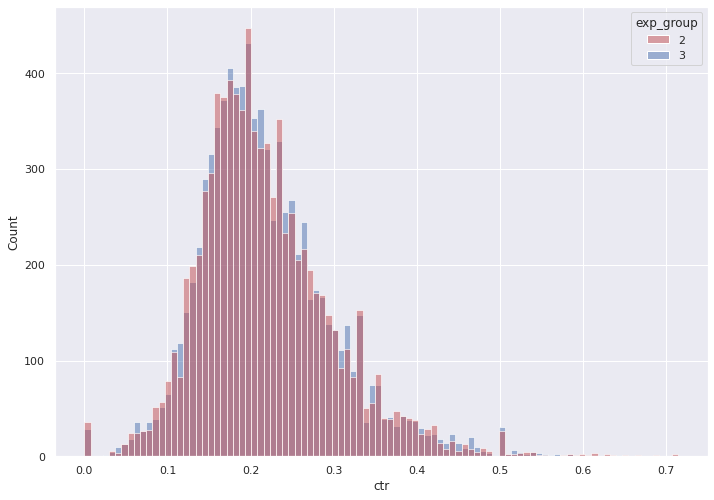

In [9]:
groups = sns.histplot(data = df, 
                      x='ctr', 
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Для сравнения проведем еще 2 эксперимента, отражающих два крайних случая. 

В первом возьмем нашу группу 3 и аналогичным способом сравним ее значения ключевой метрики со сгенерированными случайными числами, расположенными в аналогичном диапазоне - то есть их распределения должны быть совершенно разными.

In [22]:
p_vals = np.empty(10000)
random_vals = np.random.randint(df[df.exp_group == 3].ctr.min() * 10000000000,
                                df[df.exp_group == 3].ctr.max() * 10000000000,
                                8500) / 10000000000

for i in tqdm(range(10000)):
    df_3 = df[df.exp_group == 3].sample(500, replace=False)
    rand_sample = np.random.choice(random_vals, 500, replace=False)
    
    p_vals[i] = stats.ttest_ind(rand_sample, df_3.ctr)[1]

100%|██████████| 10000/10000 [00:36<00:00, 271.57it/s]


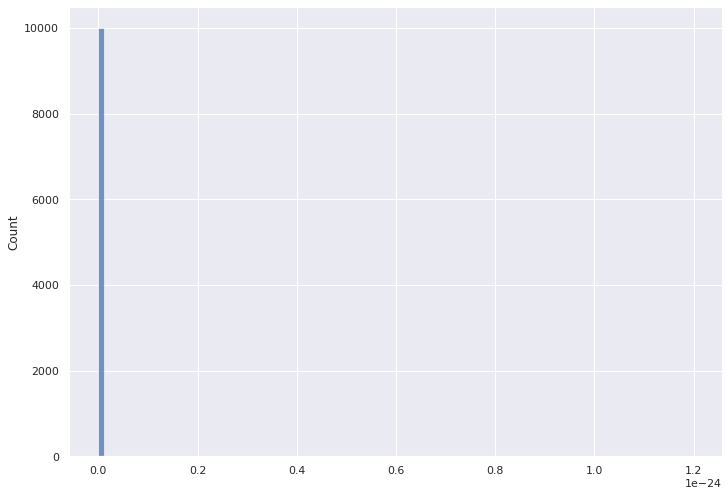

In [23]:
sns.histplot(p_vals, bins=100);

In [24]:
len(p_vals[p_vals <= 0.05]) / len(p_vals)

1.0

In [25]:
stats.ttest_ind(random_vals, df_3.ctr)

Ttest_indResult(statistic=15.209970697444652, pvalue=1.3269250860484191e-51)

Видим, что гистограмма распределения 10 000 pvalue полностью располагается у значения, близкого к нулю - доля pvalue менее 0,05 так же составляет 100 %, что характерно указывает на полную принадлежность каждой из подвыборок к разным генеральным совокупностям, t-тест это так же подтверждает.

Ну и во втором протестируем другой крайний случай - подвыборки в каждом из 10 000 тестов будут отбираться из одной совокупности - значения ключевой метрики группы 3.

In [3]:
p_vals = np.empty(10000)
p_vals_lowest = []

for i in tqdm(range(10000)):
    df_3_0 = df[df.exp_group == 3].sample(500, replace=False)
    df_3_1 = df[df.exp_group == 3].sample(500, replace=False)
    
    p_vals[i] = stats.ttest_ind(df_3_1.ctr, df_3_0.ctr)[1]
    
    # дополнительно соберем случайные подвыборки с экстремально низкими pvalue
    if p_vals[i] <= 0.001:
        p_vals_lowest.append((df_3_1.ctr.values, df_3_0.ctr.values))

100%|██████████| 10000/10000 [01:04<00:00, 156.24it/s]


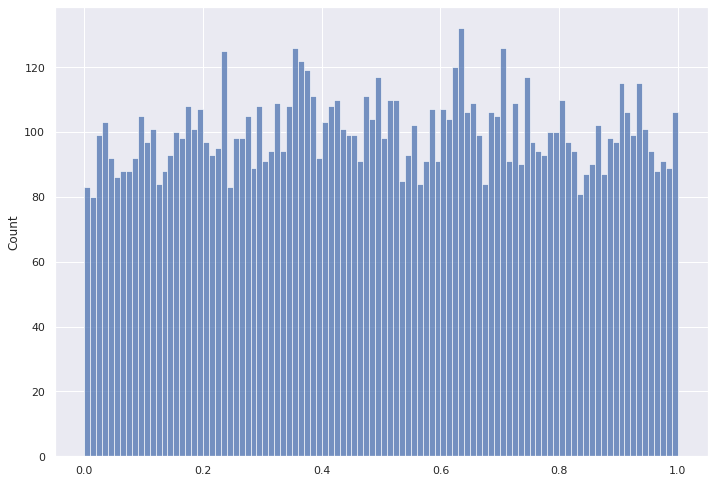

In [5]:
sns.histplot(p_vals, bins=100);

In [6]:
len(p_vals[p_vals <= 0.05]) / len(p_vals)

0.0457

In [8]:
stats.ttest_ind(df_3.ctr, df_3.ctr), stats.ttest_ind(df_3_0.ctr, df_3_1.ctr)

(Ttest_indResult(statistic=0.0, pvalue=1.0),
 Ttest_indResult(statistic=1.12621430947285, pvalue=0.26034555402772136))

Собственно, видим гистограмму и долю pvalue менее 0,05 схожие нашему основному АА тесту сравнения групп 2 и 3, что так же характерно для подвыборок из одной совокупности, что и является исходным условием нашего дополнительного третьего эксперимента. Проведение t-теста по одинаковым значениям лишено смысла (ожидаемо pvalue равно 1), поэтому для наглядности взяты подвыборки из последней итерации - pvalue составил 0,26, что так же значительно больше уровня значимости 0,05 и указывает на невозможность отклонения нулевой гипотезы о принадлежности подвыборок одной совокупности.

Посмотрим, сколько было случайных подвыборок с экстремально низкими значениями pvalue (менее 0,001), которые бы позволили отвергнуть нулевую гипотезу с совершением ошибки первого рода. 

In [9]:
len(p_vals_lowest)

7

Как видим, количество таких подвыборок незначительно (7/10000). 

Построим для наглядности гистаграммы некоторых из распределений.

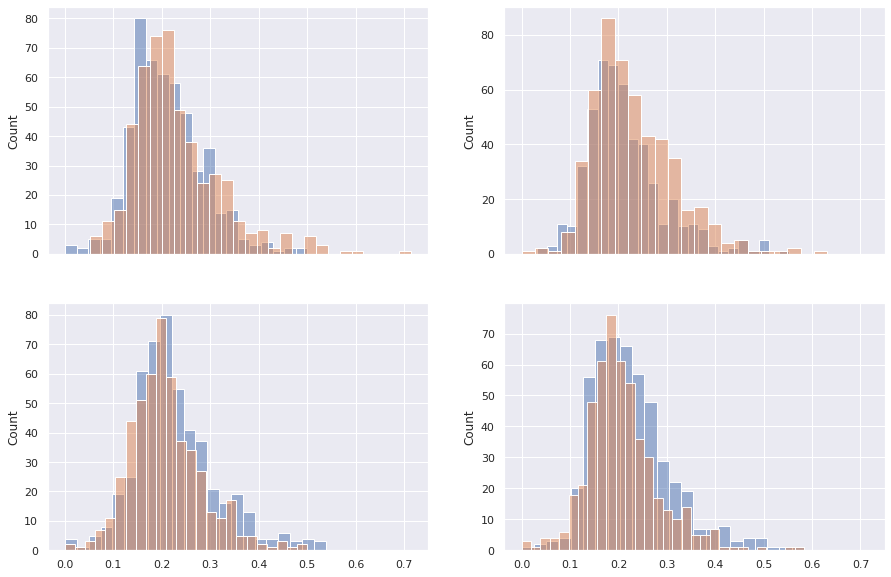

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
for ax, i in zip(axes.flatten(), range(4)):
    sns.histplot(data = p_vals_lowest[i][0],
                 alpha=0.5,
                 kde=False,
                 ax=ax)
    sns.histplot(data = p_vals_lowest[i][1],
                 alpha=0.5,
                 kde=False,
                 ax=ax)

Гистограммы распределений так же визуально отражают значительные различия случайных подвыборок.